# Info 1998 Final Project

*   Using NFL Combine data to predict Player Performance/Value in NFL
*   Authors: Brian Bobby (btb68), Max Brody (mwb226), Teddy Klausner (tjk223)

**Question:** How does NFL Combine data predict future NFL performance? Which aspects are better predictors and which are worse?

**Prediction**: A player with a strong NFL Combine will likely have a better NFL performance. Specific attributes will likely change between player positions, so we will probably isolate different positions, or sets of positions, and make separate models for each.

**Data:**
> NFL Combine data for all players in NFL Draft, 2000-2018:
> https://www.kaggle.com/savvastj/nfl-combine-data/data



> Madden satistics for all active players, 2019:
> https://www.kaggle.com/gdowling/madden-2019-ultimate-team-dataset


In [1]:
import numpy as np
import pandas as pd

# Import both files as pandas dataframes
combine_df = pd.read_csv('combine_data_since_2000_PROCESSED_2018-04-26.csv')
madden_df = pd.read_csv('Madden_Ultimate_Team.csv')

# Merge corresponding players by name
merged_df = pd.merge(left=madden_df,right=combine_df,left_on='Name',
                     right_on='Player')

# Drop unneeded columns, mostly unneeded Madden attributes.
# Also dropped Madden position, team, height, weight, because we want to predict
# future performance based solely on combine results.
merged_df.drop(['Unnamed: 0', 'Position', 'Team_x', 'Height', 'Weight', 
       'Card_set', 'Player_page', 'SPD', 'STR', 'AGI', 'ACC', 'AWR', 'CTH',
       'JMP', 'STA', 'INJ', 'TRK', 'ELU', 'BTK', 'BCV', 'SFA', 'SPM', 'JKM',
       'CAR', 'SRR', 'MRR', 'DRR', 'CIT', 'SPC', 'RLS', 'THP', 'TAS', 'TAM',
       'TAD', 'TOR', 'TUP', 'BSK', 'PAC', 'RBK', 'RBP', 'RBF', 'PBK', 'PBP',
       'PBF', 'LBK', 'IBL', 'TAK', 'POW', 'PWM', 'FNM', 'BKS', 'PUR', 'PRC',
       'MCV', 'ZCV', 'PRS', 'KPW', 'KAC', 'KR', 'Xbox_price', 'Ps4_price',
       'Quick_sell', 'Player', 'Year', 'Pfr_ID', 'AV', 'Team_y', 'Round',
       'Pick'],axis=1,inplace=True)

# It turns out that players can have multiple instances in Madden, taking the
# form of different "cards" that have different strengths/values.
# We decided to keep only the highest rated instance of each player to get a 
# consistent picture of everyone.
merged_df.drop_duplicates(subset='Name',keep='first',inplace=True)

# We also decided to drop punters and kickers, because they are a drastically
# different type of player and will likely be outliers in the data.
merged_df = merged_df[merged_df.Pos != 'K']
merged_df = merged_df[merged_df.Pos != 'P']

merged_df.reset_index(drop=True,inplace=True)
merged_df.rename(columns={'Overall':'Rating'},inplace=True)

merged_df.head()

,Name,Rating,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle
0,Calvin Johnson,94,WR,77,239,4.35,NaN,NaN,NaN,NaN,NaN
1,Kellen Winslow,94,TE,76,251,4.55,NaN,24.0,120.0,NaN,NaN
2,Drew Brees,93,QB,72,213,4.83,32.0,NaN,105.0,7.09,4.21
3,Melvin Gordon,93,RB,73,215,4.52,35.0,19.0,126.0,7.04,4.07
4,Deion Jones,93,OLB,73,222,4.59,33.0,NaN,120.0,NaN,NaN


Now we will handle the problem of missing data points. We first looked at how many missing values there were in each column:

In [2]:
print(len(merged_df[['Pos','Ht','Wt','Forty','Vertical','BenchReps','BroadJump',
                     'Cone','Shuttle']]) - merged_df[['Pos','Ht','Wt','Forty',
                     'Vertical','BenchReps','BroadJump','Cone','Shuttle']]
                     .count())
print('\nTotal Players: ',len(merged_df))

Pos            0
Ht             0
Wt             0
Forty         73
Vertical     233
BenchReps    357
BroadJump    246
Cone         443
Shuttle      418
dtype: int64

Total Players:  1402


Since Cone and Shuttle each have almost a third of the data missing, we will remove them and use only the other seven features.

In [3]:
merged_df.drop(['Cone','Shuttle'],axis=1,inplace=True)

Next, we were curious about how many NaN values was acceptable for a player to have, and how many we could accept before having too few players to work with:

In [4]:
for i in range(1,8):
    df = merged_df.dropna(thresh=i,subset=['Pos','Ht','Wt','Forty','Vertical',
                          'BenchReps','BroadJump'],inplace=False)
    print(str(i)+' required feature(s): '+str(len(df))+' players left')

1 required feature(s): 1402 players left
2 required feature(s): 1402 players left
3 required feature(s): 1402 players left
4 required feature(s): 1381 players left
5 required feature(s): 1272 players left
6 required feature(s): 1160 players left
7 required feature(s): 886 players left


After dropping all NaN values (shown above by the "7 required features" row), we still have a significant number of players left (886), and so instead of filling NaN values with means we are going to just use these 886 players that have fully complete data:

In [5]:
merged_df.dropna(subset=['Ht','Wt','Forty','Vertical','BenchReps','BroadJump'],inplace=True)
merged_df.reset_index(drop=True,inplace=True)
merged_df.head()

,Name,Rating,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump
0,Melvin Gordon,93,RB,73,215,4.52,35.0,19.0,126.0
1,Jarvis Landry,93,WR,71,205,4.65,28.5,12.0,110.0
2,Sean Lee,93,ILB,74,236,4.71,37.5,24.0,120.0
3,Geno Atkins,92,DT,73,293,4.75,33.0,34.0,117.0
4,Le'Veon Bell,92,RB,73,230,4.60,31.5,24.0,118.0


Next, we worked on making the "Pos" feature numerical, which we wanted to do using One Hot Encoding, where each position option is turned into another feature column where a value of 1 means a player is that position, and all other position columns have a value of 0. This first meant splitting our players into subgroups we believed would have similar desired traits and similar playing statistics, as we did not want to have 24 additional features to signify the 24 position options. Based on Max's football knowledge, we categorized the players into four groups instead: 

> Offensive Skill Positions (OS)
*   WR, TE, QB, RB


> Defensive Skill Positions (DS)
*   FS, CB, SS, S, DB


> Offensive Non-Skill Positions (ONS)
*   G, C, T, FB, OL, 


> Defensive Non-Skill Positions (DNS)
*   OLB, ILB, DT, DE, LB, EDGE, NT


In [6]:
#Offensive skill positions: WR, TE, QB, RB
merged_df.Pos[merged_df.Pos == 'WR'] = 'OS'
merged_df.Pos[merged_df.Pos == 'TE'] = 'OS'
merged_df.Pos[merged_df.Pos == 'QB'] = 'OS'
merged_df.Pos[merged_df.Pos == 'RB'] = 'OS'

#Defensive Skill Positions: FS, CB, SS, S, DB
merged_df.Pos[merged_df.Pos == 'FS'] = 'DS'
merged_df.Pos[merged_df.Pos == 'CB'] = 'DS'
merged_df.Pos[merged_df.Pos == 'SS'] = 'DS'
merged_df.Pos[merged_df.Pos == 'S'] = 'DS'
merged_df.Pos[merged_df.Pos == 'DB'] = 'DS'

#Offensive Non-Skill Positions: G, C, T, FB, OL, OT, OG
merged_df.Pos[merged_df.Pos == 'G'] = 'ONS'
merged_df.Pos[merged_df.Pos == 'FB'] = 'ONS'
merged_df.Pos[merged_df.Pos == 'OG'] = 'ONS'
merged_df.Pos[merged_df.Pos == 'OL'] = 'ONS'
merged_df.Pos[merged_df.Pos == 'OT'] = 'ONS'
merged_df.Pos[merged_df.Pos == 'C'] = 'ONS'

#Defensive Non-skill Positions: OLB, ILB, DT, DE, LB, EDGE, NT
merged_df.Pos[merged_df.Pos == 'OLB'] = 'DNS'
merged_df.Pos[merged_df.Pos == 'ILB'] = 'DNS'
merged_df.Pos[merged_df.Pos == 'DT'] = 'DNS'
merged_df.Pos[merged_df.Pos == 'DE'] = 'DNS'
merged_df.Pos[merged_df.Pos == 'LB'] = 'DNS'
merged_df.Pos[merged_df.Pos == 'EDGE'] = 'DNS'
merged_df.Pos[merged_df.Pos == 'NT'] = 'DNS'

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/A

We then used the One Hot Encoding technique to create new position columns using these four categories:

In [7]:
#One Hot Encoding
merged_df['Pos'] = pd.Categorical(merged_df['Pos'])
dfDummies = pd.get_dummies(merged_df['Pos'], prefix = 'category')
OHE_df = pd.concat([merged_df, dfDummies], axis=1)
OHE_df.head()

,Name,Rating,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,category_DNS,category_DS,category_ONS,category_OS
0,Melvin Gordon,93,OS,73,215,4.52,35.0,19.0,126.0,0,0,0,1
1,Jarvis Landry,93,OS,71,205,4.65,28.5,12.0,110.0,0,0,0,1
2,Sean Lee,93,DNS,74,236,4.71,37.5,24.0,120.0,1,0,0,0
3,Geno Atkins,92,DNS,73,293,4.75,33.0,34.0,117.0,1,0,0,0
4,Le'Veon Bell,92,OS,73,230,4.60,31.5,24.0,118.0,0,0,0,1


Now we have all numerical features, a numerical target, and no missing data. Our next step is to start modelling. We had hoped that a simple Linear Regression model would fit the data, but after looking at the below correlation matrix, we were doubtful:

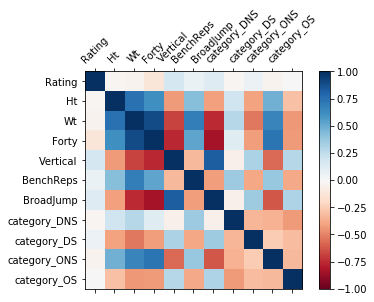

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

corr = OHE_df.corr()

fig = plt.figure()
ax = fig.add_subplot(111)
fig.colorbar(ax.matshow(corr, cmap='RdBu', vmin=-1, vmax=1))

ax.set_xticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns)
for tick in ax.get_xticklabels():
        tick.set_rotation(45)

ax.set_yticks(range(len(corr.columns)))
ax.set_yticklabels(corr.columns)

plt.show()

As you can see, the row that relates Rating to all of our features is basically white, meaning there aren't any strong linear relationships. Nonetheless, we created a Linear Regression model using all 11 features with the aim of predicting each player's overall rating:

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X = OHE_df.drop(['Name', 'Rating', 'Pos'], axis=1)
Y = OHE_df['Rating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2,random_state=13)
model = LinearRegression()
model.fit(X_train, Y_train)
print('LinReg score: ',model.score(X_test, Y_test))

LinReg score:  0.05620849343235734


With repeated random splits, we could not get our model score over 0.1, so we decided to try a Decision Tree Regressor next to see if that could better fit our data, testing different depths to see what would give us the best results:

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

X = OHE_df.drop(['Name', 'Rating', 'Pos'], axis=1)
Y = OHE_df['Rating']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2,random_state=13)


train_scores = []
test_scores = []

max_depths = list(range(1,100))
max_score_te = -1
max_score_tr = -1
depth = 0
for i in max_depths:
    model = DecisionTreeRegressor(max_depth=i)
    model.fit(x_train, y_train)
    test_score = model.score(x_test, y_test)
    if test_score > max_score_te:
        max_score_te = test_score
        max_score_tr = model.score(x_train, y_train)
        depth = i
print('DecisionTreeRegressor:')
print('    depth: ',depth)
print('    max training score: ',max_score_tr)
print('    max testing score: ',max_score_te)

DecisionTreeRegressor:
    depth:  1
    max training score:  0.030040815213867478
    max testing score:  0.009789102652305703


Obviously, the Decision Tree Regressor didn't give us great results either. We next decided to look at the distribution of ratings to see if anything unusual was happening, or if there were obvious visual categories we could bin our ratings into to simplify our model:

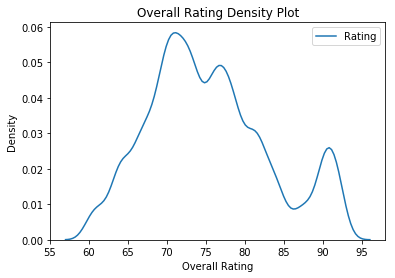

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.subplot()
sns.kdeplot(OHE_df['Rating'], bw=1)

plt.title ('Overall Rating Density Plot')
plt.xlabel('Overall Rating')
plt.ylabel('Density')

plt.show()

Based on this visual, we decided to bin our data into three categories:


*   great players, with a rating of at least 85

*   good players, with a rating less than 85 but at least 65

*   bad players, with a rating less than 65






In [12]:
OHE_df['categ'] = 'great'
OHE_df.categ[OHE_df.Rating < 85] = 'good'
OHE_df.categ[OHE_df.Rating < 65] = 'bad'

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
OHE_df.head()

,Name,Rating,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,category_DNS,category_DS,category_ONS,category_OS,categ
0,Melvin Gordon,93,OS,73,215,4.52,35.0,19.0,126.0,0,0,0,1,great
1,Jarvis Landry,93,OS,71,205,4.65,28.5,12.0,110.0,0,0,0,1,great
2,Sean Lee,93,DNS,74,236,4.71,37.5,24.0,120.0,1,0,0,0,great
3,Geno Atkins,92,DNS,73,293,4.75,33.0,34.0,117.0,1,0,0,0,great
4,Le'Veon Bell,92,OS,73,230,4.60,31.5,24.0,118.0,0,0,0,1,great


In [14]:
OHE_df.tail()

,Name,Rating,Pos,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,category_DNS,category_DS,category_ONS,category_OS,categ
881,Allen Barbre,60,ONS,76,300,4.84,32.0,28.0,105.0,0,0,1,0,bad
882,Robert Blanton,60,DS,73,208,4.66,34.0,12.0,116.0,0,1,0,0,bad
883,Alex Boone,60,ONS,79,328,5.16,27.5,33.0,103.0,0,0,1,0,bad
884,Jahri Evans,60,ONS,76,316,5.25,27.0,20.0,95.0,0,0,1,0,bad
885,Anthony Fasano,60,OS,76,259,4.72,33.5,19.0,112.0,0,0,0,1,bad


For our first classification model, we tried a KNeighbors Classifier:

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


X = OHE_df.drop(['Name', 'Rating', 'Pos', 'categ'], axis=1)
Y = OHE_df['categ']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 13)
model = KNeighborsClassifier(n_neighbors=7)
model.fit(x_train, y_train)
predictions = model.predict(x_test)

print("KNeighbors accuracy score:", accuracy_score(y_test, predictions))

KNeighbors accuracy score: 0.7865168539325843


This seemed like a promising jump in accuracy at first, but while playing around with this model, we found that almost any way we modified resulted in the same score. So we decided to print out our predictions:

In [16]:
print(predictions)

['good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'great' 'good' 'good' 'good' 'bad' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'great' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'great' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'bad' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'goo

And there was the problem — our middle bin was too large and the model was simply dumping all the players in there. To fix this, we decided to bin using the 33rd and 66th percentile, to get a more even distribution of data:

In [17]:
OHE_df['categ'] = 'great'
OHE_df.categ[OHE_df.Rating < OHE_df.Rating.quantile(.66)] = 'good'
OHE_df.categ[OHE_df.Rating < OHE_df.Rating.quantile(.33)] = 'bad'

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We then ran the KNeighbors Classifier again:

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


X = OHE_df.drop(['Name', 'Rating', 'Pos', 'categ'], axis=1)
Y = OHE_df['categ'] 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 13)
model = KNeighborsClassifier(n_neighbors=7)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
score = accuracy_score(y_test, predictions)

print("sklearn's accuracy score:", score)
print(predictions)

sklearn's accuracy score: 0.39325842696629215
['good' 'good' 'good' 'great' 'great' 'good' 'good' 'good' 'great' 'good'
 'bad' 'good' 'great' 'great' 'bad' 'bad' 'bad' 'great' 'good' 'great'
 'good' 'great' 'great' 'great' 'good' 'bad' 'great' 'bad' 'great' 'great'
 'good' 'bad' 'bad' 'bad' 'bad' 'good' 'good' 'good' 'great' 'good'
 'great' 'great' 'great' 'great' 'good' 'good' 'good' 'good' 'great' 'bad'
 'bad' 'good' 'bad' 'great' 'good' 'bad' 'bad' 'great' 'bad' 'bad' 'bad'
 'bad' 'great' 'great' 'bad' 'bad' 'bad' 'good' 'good' 'good' 'good'
 'good' 'great' 'great' 'great' 'good' 'bad' 'good' 'bad' 'good' 'great'
 'great' 'great' 'good' 'great' 'great' 'great' 'good' 'great' 'good'
 'good' 'great' 'great' 'bad' 'great' 'good' 'great' 'bad' 'good' 'great'
 'good' 'good' 'great' 'bad' 'bad' 'good' 'good' 'bad' 'bad' 'good' 'good'
 'bad' 'good' 'good' 'good' 'good' 'good' 'great' 'bad' 'great' 'great'
 'great' 'good' 'good' 'good' 'bad' 'bad' 'bad' 'great' 'bad' 'bad' 'good'
 'bad' 'ba

And we finally got a successful model, as this accuracy is technically better than just random guessing. In another bid to improve our accuracy, we tried a Decision Tree Classifier:

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X = OHE_df.drop(['Name', 'Rating', 'Pos', 'categ'], axis=1)
Y = OHE_df['categ']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=13 )


train_scores = []
test_scores = []

max_depths = list(range(1,100))
max_score_te = -1
max_score_tr = -1
depth = 0
for i in max_depths:
    model = DecisionTreeClassifier(max_depth=i)
    model.fit(x_train, y_train)
    test_score = model.score(x_test, y_test)
    if test_score > max_score_te:
        max_score_te = test_score
        max_score_tr = model.score(x_train, y_train)
        depth = i
        predictions = model.predict(x_test)
print('DecisionTreeClassifier:')
print('    depth: ',depth)
print('    max training score: ',max_score_tr)
print('    max testing score: ',max_score_te)

DecisionTreeClassifier:
    depth:  1
    max training score:  0.384180790960452
    max testing score:  0.4044943820224719


And a final attempt was an svm gridsearch:

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split

X = OHE_df.drop(['Name', 'Rating', 'Pos', 'categ'], axis=1)
Y = OHE_df['categ']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=13)



model = svm.SVC(kernel='linear', C=0.01,gamma=1)
model.fit(X_train, Y_train)
model.predict(X_test)
print("Model score for hard coded parameters: ", model.score(X_test,Y_test))
print()

# give the grid search options to iterate over
Cs = [0.01, 0.1, 1, 10] # fill in this list with possible values you want to search over
gammas = [0.01, 0.1, 1, 10] # fill in this list with possible values you want to search over
param_grid = {'gamma': gammas, 'C':Cs} # fill in this dictionary. to contain Cs and gammas. 
                # See documentation for sklearn.model_selection.GridSearchCV for an example.

# create the GridSearch model
grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid)
# fit the model
grid_search.fit(X_train, Y_train)

# we use the grid search parameters
model = svm.SVC(kernel='linear', C=grid_search.best_params_['C'],gamma=grid_search.best_params_['gamma'])
model.fit(X_train, Y_train)
model.predict(X_test)
print()
print("Model score for grid search parameters: ", model.score(X_test,Y_test))
print('C: ',grid_search.best_params_['C'],'gamma: ',grid_search.best_params_['gamma'])

Model score for hard coded parameters:  0.34831460674157305


Model score for grid search parameters:  0.38764044943820225
C:  1 gamma:  0.01


Based on all of our attempted models, it seems like NFL Combine data alone is a somewhat inadequate predictor of actual NFL performance, at least when measured by Madden player ratings. At this point, we thought it would be interesting to explore whether our model was mostly overpredicting or underpredicting player performance.

In [21]:
indeces = list(X_test.index)
a = OHE_df.loc[indeces,:]
a['pred'] = predictions
a.drop(['Pos','Ht','Wt','Forty','Vertical','BenchReps','BroadJump','category_DNS','category_DS','category_ONS','category_OS'],axis=1,inplace=True)
a['correct'] = np.where(a.categ == a.pred, 1, 0)
a.head(10)

,Name,Rating,categ,pred,correct
731,Chase Edmonds,68,bad,great,0
224,Andy Levitre,80,great,good,0
460,Kevin Minter,74,good,good,1
745,Duke Riley,68,bad,great,0
601,Joel Iyiegbuniwe,71,good,great,0
384,Brandon Mebane,76,good,good,1
63,Steve Hutchinson,90,great,good,0
871,David Harris,61,bad,good,0
780,John Wetzel,67,bad,good,0
831,Ethan Cooper,64,bad,good,0


In [22]:
print('We got ',a['correct'].sum(),'out of ',len(a),'players correct')

We got  72 out of  178 players correct


To do this, we categorized the players in our predicted test set from our best model, the Decision Tree Classifier, into the following categories:

*   Underpredicted by 2, for example if we predicted a 'great' player to be 'bad'

*   Underpredicted by 1, for example if we predicted a 'great' player to be 'good'

*   Correct, meaning our prediction matched the player's actual category

*   Overpredicted by 1, for example if we predicted a 'good' player to be 'great'

*   Overpredicted by 2, for example if we predicted a 'bad' player to be 'great'

In [23]:
a['compare'] = ''
a.compare[(a.pred == 'bad') & (a.categ == 'great')] = 'under2'
a.compare[(a.pred == 'good') & (a.categ == 'great')] = 'under1'
a.compare[(a.pred == 'bad') & (a.categ == 'good')] = 'under1'
a.compare[(a.pred == 'bad') & (a.categ == 'bad')] = 'correct'
a.compare[(a.pred == 'good') & (a.categ == 'good')] = 'correct'
a.compare[(a.pred == 'great') & (a.categ == 'great')] = 'correct'
a.compare[(a.pred == 'great') & (a.categ == 'good')] = 'over1'
a.compare[(a.pred == 'good') & (a.categ == 'bad')] = 'over1'
a.compare[(a.pred == 'great') & (a.categ == 'bad')] = 'over2'

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/A

In [24]:
a.head()

,Name,Rating,categ,pred,correct,compare
731,Chase Edmonds,68,bad,great,0,over2
224,Andy Levitre,80,great,good,0,under1
460,Kevin Minter,74,good,good,1,correct
745,Duke Riley,68,bad,great,0,over2
601,Joel Iyiegbuniwe,71,good,great,0,over1


In [25]:
a['compare'].value_counts()

correct    72
over1      57
under1     30
over2      19
Name: compare, dtype: int64

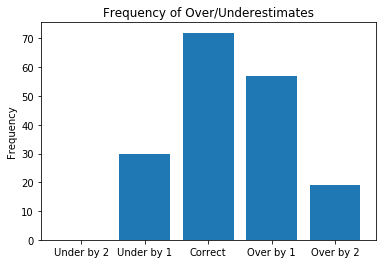

In [26]:
plt.bar([0,1,2,3,4],[0,30,72,57,19],align='center')

plt.title('Frequency of Over/Underestimates')
plt.xticks([0,1,2,3,4],['Under by 2','Under by 1','Correct','Over by 1','Over by 2'])
plt.ylabel('Frequency')

plt.show()

This graph offers an interesting insight into how our model performed. It seems as though we were good at ensuring that players who were 'great' in reality weren't ever classified as 'bad', i.e. we didn't underpredict anyone by two categories. On the other hand, we overpredicted more players than we actually got correct. Relating this to real life, an explanation could be that for a player to enter the NFL Combine in the first place, they have already exceeded a certain physical threshold that comes along with being an almost-professional athlete. In this way, it could be hard to discern which players are actually 'great' when most players' physical performances in the Combine are on par with or exceed that of 'great' players. In conclusion, predicting NFL players' performance based solely on their Combine data proved to be difficult, probably for the aforementioned reason, however we were able to provide a model that was an improvement over guessing to help categorize players into their likeliest category of 'bad', 'good', or 'great'.